## Download UCF101 dataset

In [ ]:
!wget https://www.crcv.ucf.edu/data/UCF101/UCF101.rar --no-check-certificate

--2020-12-09 19:21:37--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/rar]
Saving to: ‘UCF101.rar’

UCF101.rar            2%[                    ] 194.76M  25.6MB/s    eta 4m 12s ^C


## Unrar into videos folder

In [ ]:
!mkdir videos && unrar e UCF101.rar ./videos -idq

### Count videos

In [ ]:
!ls videos | wc -l

51


In [ ]:
!rm UCF101.rar

In [ ]:
!mkdir images

## Lib used split videos into frames

In [ ]:
!apt-get install imagemagick > /dev/null

In [ ]:
import os

## The 3 exercises we want to recognize

In [ ]:
wanted_categories = ['PushUps', 'PullUps', 'BodyWeightSquats']

## Iterate over all videos and save frames to category folders<br>Videos belonging to neither category go to 'Other' folder

In [ ]:
for c in wanted_categories:
  os.makedirs(f'images/{c}')
#os.makedirs(f'images/Other')

In [ ]:
num_videos_from_wanted = 0
for i, file in enumerate(os.listdir('videos')):
  category = file.split('_')[1]
  if category not in wanted_categories:
    continue
  
  num_videos_from_wanted += 1
  os.system(f'convert videos/{file} "images/{category}/frame{i}%03d.jpg"')

In [ ]:
print(num_videos_from_wanted)

319


In [ ]:
'''num_videos_from_other = 0
for i, file in enumerate(os.listdir('videos')):
  category = file.split('_')[1]
  if category in wanted_categories:
    continue

  num_videos_from_other += 1
  os.system(f'convert videos/{file} "images/Other/frame{i}%03d.jpg"')
  if num_videos_from_other == num_videos_from_wanted:
    break'''

## Number of images in each category

In [ ]:
!ls images/BodyWeightSquats/ | wc -l

22571


In [ ]:
!ls images/PushUps/ | wc -l

13726


In [ ]:
!ls images/PullUps/ | wc -l

23298


In [ ]:
!ls images/Other/ | wc -l

59474


## Number of all images

In [ ]:
!ls images/* | wc -l

59600


In [ ]:
import cv2
import matplotlib.pyplot as plt

## We chose EfficientNet as the base model, because it puts less load on machines (like a webserver)

In [ ]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet, mobilenet_v2
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [ ]:
# Fix random seeds for training
seed = 1337
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) # only for the B0 version of EfficientNet

In [ ]:
# Set up data augmentation
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    data_format='channels_last',
    rotation_range=20,
    shear_range=15,
    zoom_range=0.3)

# Train/validation data from directories
train_flow = data_generator.flow_from_directory(
    directory='images/', shuffle=True,
    batch_size=BATCH_SIZE, target_size=IMG_SIZE)

val_flow = data_generator.flow_from_directory(
    directory='images/', shuffle=True, subset='validation', 
    batch_size=BATCH_SIZE, target_size=IMG_SIZE)

Found 59595 images belonging to 3 classes.
Found 11918 images belonging to 3 classes.


In [ ]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# input_size for B0: (224, 224, 3)
base_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False # we only train the output layers

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
NUM_CLASSES = len(wanted_categories)# + 1 # 3 exercises + other

In [ ]:
# flatten convolutional output with average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, 'relu')(x)
# Output probability for the 4 classes
output = tf.keras.layers.Dense(NUM_CLASSES, 'softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
# Train model
model.fit(
    x=train_flow,
    epochs=1,
    validation_data=val_flow,
    validation_steps=8
)

In [ ]:
model.evaluate(val_flow)

94/94 [==============================] - 134s 1s/step - loss: 0.0020 - accuracy: 0.9996


[0.002010841853916645, 0.999580442905426]

## Test the trained model on some images and videos

In [ ]:
test = plt.imread('horseriding.jpg')

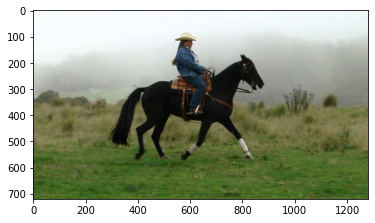

In [ ]:
plt.imshow(test)

In [ ]:
# invert dict to index: category name
cat_mapping = {v: k for k, v in train_flow.class_indices.items()}

In [ ]:
cat_mapping

{0: 'BodyWeightSquats', 1: 'PullUps', 2: 'PushUps'}

In [ ]:
# return category with highest prob. value
def category_from_preds(preds):
  return cat_mapping[np.argmax(preds)]

In [ ]:
# return predicted category for an image
def predict_image(image):
  # preprocessing
  image = cv2.resize(image, IMG_SIZE)
  image = preprocess_input(image)
  image = tf.expand_dims(image, axis=0)

  preds = model.predict(image) # predict probabilities
  return category_from_preds(preds), np.argmax(preds), np.amax(preds)

In [ ]:
predict_image(test)

NameError: ignored

## Test on first 500 frames of a video

In [ ]:
test_fname = None
for file in os.listdir('videos/'):
  if 'pushup' in file.lower():
    test_fname = 'videos_extr/' + file
    break

print(test_fname)

videos_extr/Chest_workout-_hip_pushups_pushup_u_nm_np1_fr_med_4.avi


In [ ]:
classes = {0: 'BodyWeightSquats', 1: 'PullUps', 2: 'PushUps'}

In [ ]:
path = f'{test_fname}'
vidcap = cv2.VideoCapture(path)
count = 1
frames = []
good = 0
bad = 0
for i in range(500):
  success, frame = vidcap.read()
  if not success:
    break

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  #image = cv2.rotate(image, cv2.ROTATE_180)
  image = cv2.resize(image, IMG_SIZE)
  frames.append(image)
  print('frame', count, end=' ')
  image = preprocess_input(image)
  image = tf.expand_dims(image, axis=0)
  preds = model.predict(image)
  #label = predict_image(image)
  if np.amax(preds) > 0.9:
    label = classes[np.argmax(preds)]
  else: label = 'Unknown'
  if label != 'PushUps':
    bad += 1
  else: good += 1
  print(label, np.amax(preds))

  count += 1

frame 1 PushUps 0.9999882
frame 2 PushUps 0.9999145
frame 3 PushUps 0.99998546
frame 4 PushUps 0.9995908
frame 5 PushUps 0.99998486
frame 6 PushUps 0.9999981
frame 7 PushUps 0.9999999
frame 8 PushUps 0.9999999
frame 9 PushUps 0.9999981
frame 10 PushUps 0.9999105
frame 11 PushUps 0.9998555
frame 12 PushUps 0.99996686
frame 13 PushUps 0.9999813
frame 14 PushUps 0.9999999
frame 15 PushUps 0.9999999
frame 16 PushUps 0.9999993
frame 17 PushUps 0.9999851
frame 18 PushUps 0.9999069
frame 19 PushUps 0.9999237
frame 20 PushUps 0.9999927
frame 21 PushUps 0.9999931
frame 22 PushUps 0.99993336
frame 23 PushUps 0.99944276
frame 24 PushUps 0.9996207
frame 25 PushUps 0.9997619
frame 26 PushUps 0.9998054
frame 27 PushUps 0.9995708
frame 28 PushUps 0.9999703
frame 29 PushUps 0.9999865
frame 30 PushUps 0.99999607
frame 31 PushUps 0.9999243
frame 32 PushUps 0.9999814
frame 33 PushUps 0.9999919
frame 34 PushUps 0.9999982
frame 35 PushUps 1.0
frame 36 PushUps 0.9999999
frame 37 PushUps 0.9999994
frame 38 P

In [ ]:
print(good/(good+bad))

1.0


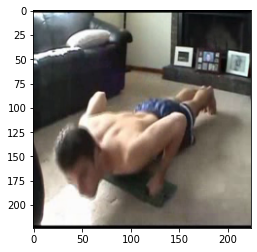

In [ ]:
plt.imshow(frames[-1])

## Save model in h5 and json format

In [ ]:
model.save('mobilenet-model.h5')

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 112kB 8.1MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0


In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model, 'js_model')

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
